# Introduction
The research questions is as follows: <br>
<br>
How different variables such as **actual delivery time**, **the difference between actual and estimated wait time**, **freight value**, **payment value**, **payment installment** affect the **review score** in each of the different **product type categories**, `Houseware`, `auto`, `furniture decor`, `computer accessories`, `health beauty`, `sports leisure`? <br>

In this python notebook, the `max_depth` and `n_estimators` obtained from the GV search is run into random forest to obtain the classification accuracy, true positive, true negative, false positive, false negative values. 

All the extracting and cleaning codes are similar to earlier parts. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [2]:
olist_orders_dataset = pd.read_csv("olist_orders_dataset.csv")
olist_order_reviews_dataset = pd.read_csv("olist_order_reviews_dataset.csv")
olist_order_payments_dataset = pd.read_csv("olist_order_payments_dataset.csv")
olist_order_items_dataset = pd.read_csv("olist_order_items_dataset.csv")
olist_products_dataset = pd.read_csv("olist_products_dataset.csv")
product_category_name_translation = pd.read_csv("product_category_name_translation.csv")

### Merging the Datasets

In [3]:
olist_merge = olist_orders_dataset.merge(olist_order_reviews_dataset, on="order_id", how = 'left')
olist_merge = olist_merge.merge(olist_order_payments_dataset, on="order_id", how = 'left')
olist_merge = olist_merge.merge(olist_order_items_dataset, on="order_id", how = 'left')
olist_merge = olist_merge.merge(olist_products_dataset, on="product_id", how = 'left')

### Removing Duplicates and extracting needed variables 

In [4]:
olist_merge.drop_duplicates(subset=["review_score", "order_id"], inplace = True)

In [5]:
dataAnalysis = pd.DataFrame(olist_merge[['order_status','order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_score', 'payment_installments', 'payment_value', 'freight_value', 'product_category_name']])

In [6]:
# Creating a list of the time related variables 
time = ["order_purchase_timestamp","order_estimated_delivery_date","order_delivered_customer_date", "order_approved_at"]
# Changing the time related variables to datetime format using the list 
for column in time:
    dataAnalysis.loc[:, column] = pd.to_datetime(dataAnalysis[column])

In [7]:
# Calculating the actual wait time    
dataAnalysis.loc[:,"actual_wait_time"] = (dataAnalysis['order_delivered_customer_date']-dataAnalysis['order_purchase_timestamp']).dt.days

In [8]:
# Calculating the estimated wait time 
dataAnalysis.loc[:,"estimated_wait_time"] = (dataAnalysis['order_estimated_delivery_date']-dataAnalysis['order_purchase_timestamp']).dt.days

In [9]:
#Actual minus estimated wait time 
dataAnalysis.loc[:,"actualxestimated"] = (dataAnalysis['actual_wait_time']-dataAnalysis['estimated_wait_time'])

In [10]:
dataAnalysis.drop(columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'estimated_wait_time'], inplace = True)

In [11]:
dataAnalysis = dataAnalysis.loc[(dataAnalysis["order_status"]=="delivered")]

In [12]:
# Calculating the actual wait time    
dataAnalysis.loc[:,"reviewscore"] = dataAnalysis["review_score"]//4

In [13]:
# Original review score no longer needed
dataAnalysis.drop(columns = ['review_score'], inplace = True)

In [14]:
#merging with english name first 
dataAnalysis = pd.merge(dataAnalysis,product_category_name_translation,how="left",on="product_category_name")

In [15]:
housewareProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="housewares")]

# Defining a balance function to balance the two classes
def balancing(dataframe):
    # Class count
    count_class_1, count_class_0 = dataframe.reviewscore.value_counts() #split the dataframe based on review scores into 1 and 0

    # Divide by class 1 and 0 to create two different dataframes
    df_class_0 = dataframe[dataframe['reviewscore'] == 0] 
    df_class_1 = dataframe[dataframe['reviewscore'] == 1]

    #Sample the class 0 (review score 0) by the number of review 1s
    df_class_0_over = df_class_0.sample(count_class_1, replace=True)
    dataframe = pd.concat([df_class_1, df_class_0_over], axis=0)
    return dataframe #return the dataframe

housewareProd = balancing(housewareProd)
# since there is no null values, no further cleaning is required. 

In [16]:
autoProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="auto")]

In [17]:
#Needs cleaning and removal of null values 
autoProd = autoProd.loc[(autoProd["actual_wait_time"].notnull())]
autoProd=balancing(autoProd)

In [18]:
#No need further cleaning
furnitureProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="furniture_decor")]
furnitureProd = balancing(furnitureProd)

In [19]:
CompAcProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="computers_accessories")]

In [20]:
#Needs cleaning and removal of null values 
CompAcProd = CompAcProd.loc[(CompAcProd["actual_wait_time"].notnull())]
CompAcProd=balancing(CompAcProd)

In [21]:
healthProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="health_beauty")]

In [22]:
#Needs further cleaning 
healthProd = healthProd.loc[(healthProd["payment_installments"].notnull())]
healthProd=balancing(healthProd)

In [23]:
sportsProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="sports_leisure")]

In [24]:
#Needs further cleaning 
sportsProd = sportsProd.loc[(sportsProd["actual_wait_time"].notnull())]
sportsProd=balancing(sportsProd)

#### Creating function for random forest on the product types with parameters estim and mdepth

In [27]:
def train_and_predict(dataframe, estim, mdepth):
    # Import essential models and functions from sklearn
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix

    # Extract Response and Predictors
    y = pd.DataFrame(dataframe['reviewscore'])
    X = pd.DataFrame(dataframe[["payment_installments", "payment_value", "freight_value", "actual_wait_time", "actualxestimated"]]) 

    # Split the Dataset into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

    # Import RandomForestClassifier model from Scikit-Learn
    from sklearn.ensemble import RandomForestClassifier

    # Create the Random Forest object
    rforest = RandomForestClassifier(n_estimators = estim,  # n_estimators denote number of trees
                                     max_depth = mdepth)       # set the maximum depth of each tree

    # Fit Random Forest on Train Data
    rforest.fit(X_train, y_train.reviewscore.ravel())

    # Predict the Response corresponding to Predictors
    y_train_pred = rforest.predict(X_train)
    y_test_pred = rforest.predict(X_test)
    
    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model: Train Dataset")
    print("Classification Accuracy : ", rforest.score(X_train, y_train))
    confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
    TN = confusion_matrix_train[0,0]
    TP = confusion_matrix_train[1,1]
    FP = confusion_matrix_train[0,1]
    FN = confusion_matrix_train[1,0]
    print("True Negative Rate      : ", TN/(TN+FP))
    print("True Positive Rate      : ", TP/(TP+FN))
    print("False Negative Rate     : ", FN/(FN+TP))
    print("False Positive Rate     : ", FP/(TN+FP))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model: Test Dataset")
    print("Classification Accuracy : ", rforest.score(X_test, y_test))
    confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
    TN = confusion_matrix_test[0,0]
    TP = confusion_matrix_test[1,1]
    FP = confusion_matrix_test[0,1]
    FN = confusion_matrix_test[1,0]
    print("True Negative Rate      : ", TN/(TN+FP))
    print("True Positive Rate      : ", TP/(TP+FN))
    print("False Negative Rate     : ",FN/(FN+TP))
    print("False Positive Rate     : ", FP/(TN+FP))

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusion_matrix(y_train, y_train_pred),
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0], cmap="Greens")
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1], cmap="Greens")

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9950722733245729
True Negative Rate      :  0.9982308712958867
True Positive Rate      :  0.9919739696312364
False Negative Rate     :  0.008026030368763558
False Positive Rate     :  0.0017691287041132243

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9060446780551905
True Negative Rate      :  0.9693486590038314
True Positive Rate      :  0.8389715832205683
False Negative Rate     :  0.16102841677943167
False Positive Rate     :  0.03065134099616858


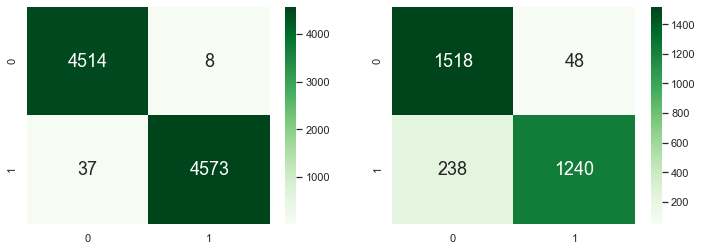

In [28]:
train_and_predict(sportsProd, 10, 800)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9935256032960565
True Negative Rate      :  0.997946611909651
True Positive Rate      :  0.9890758783584293
False Negative Rate     :  0.010924121641570712
False Positive Rate     :  0.002053388090349076

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.8804060017652251
True Negative Rate      :  0.9625668449197861
True Positive Rate      :  0.7998251748251748
False Negative Rate     :  0.20017482517482518
False Positive Rate     :  0.0374331550802139


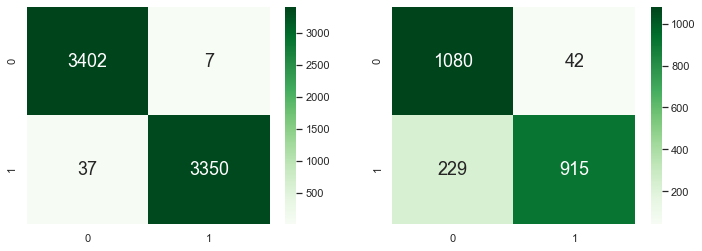

In [29]:
train_and_predict(housewareProd, 10, 400)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9930043124101581
True Negative Rate      :  0.9986577181208054
True Positive Rate      :  0.9873563218390805
False Negative Rate     :  0.01264367816091954
False Positive Rate     :  0.0013422818791946308

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.8916355274504167
True Negative Rate      :  0.9592422502870264
True Positive Rate      :  0.8238341968911918
False Negative Rate     :  0.17616580310880828
False Positive Rate     :  0.04075774971297359


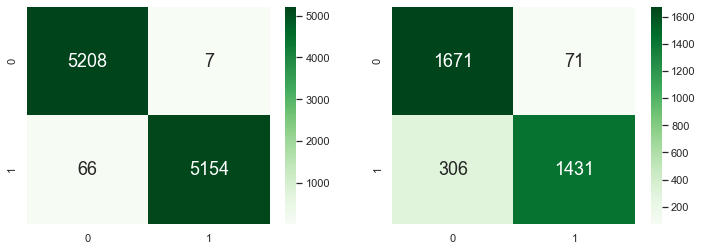

In [30]:
train_and_predict(healthProd, 10, 800)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9929046563192905
True Negative Rate      :  0.9964773227653017
True Positive Rate      :  0.9892809289861545
False Negative Rate     :  0.010719071013845467
False Positive Rate     :  0.0035226772346983706

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.879654255319149
True Negative Rate      :  0.9510869565217391
True Positive Rate      :  0.8111979166666666
False Negative Rate     :  0.18880208333333334
False Positive Rate     :  0.04891304347826087


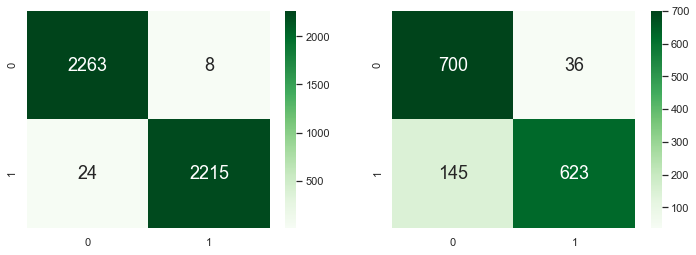

In [31]:
train_and_predict(autoProd, 10, 500)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9901804670912951
True Negative Rate      :  0.9967724583109199
True Positive Rate      :  0.9837611314824516
False Negative Rate     :  0.016238868517548456
False Positive Rate     :  0.0032275416890801506

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.8602707006369427
True Negative Rate      :  0.9532924961715161
True Positive Rate      :  0.7595356550580431
False Negative Rate     :  0.24046434494195687
False Positive Rate     :  0.04670750382848392


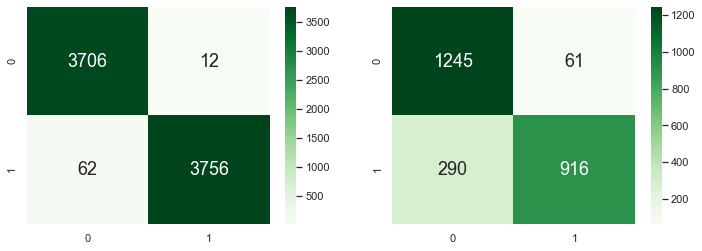

In [32]:
train_and_predict(CompAcProd, 10, 500)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9915290131300296
True Negative Rate      :  0.9960306209242983
True Positive Rate      :  0.9870641169853769
False Negative Rate     :  0.012935883014623173
False Positive Rate     :  0.00396937907570173

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.8513341804320204
True Negative Rate      :  0.9322175732217574
True Positive Rate      :  0.7684391080617495
False Negative Rate     :  0.23156089193825044
False Positive Rate     :  0.06778242677824267


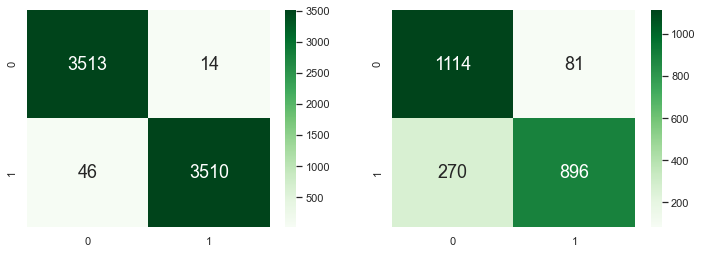

In [33]:
train_and_predict(furnitureProd, 10, 200)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9971528690319754
True Negative Rate      :  0.9980070859167405
True Positive Rate      :  0.996317157712305
False Negative Rate     :  0.003682842287694974
False Positive Rate     :  0.001992914083259522

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9329829172141918
True Negative Rate      :  0.9701017811704835
True Positive Rate      :  0.8933423913043478
False Negative Rate     :  0.10665760869565218
False Positive Rate     :  0.02989821882951654


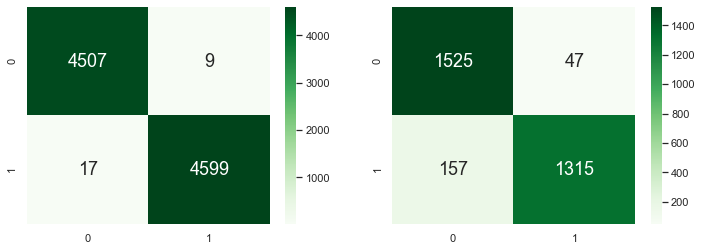

In [34]:
train_and_predict(sportsProd, 13, 900)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9972042377869335
True Negative Rate      :  0.999117387466902
True Positive Rate      :  0.9952899617309391
False Negative Rate     :  0.0047100382690609364
False Positive Rate     :  0.00088261253309797

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9143865842894969
True Negative Rate      :  0.9567137809187279
True Positive Rate      :  0.8721340388007055
False Negative Rate     :  0.12786596119929453
False Positive Rate     :  0.04328621908127209


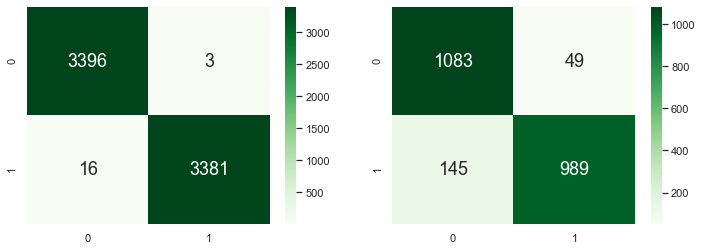

In [35]:
train_and_predict(housewareProd, 13, 600)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.995495927168184
True Negative Rate      :  0.999239977199316
True Positive Rate      :  0.9916860015467904
False Negative Rate     :  0.008313998453209591
False Positive Rate     :  0.0007600228006840206

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.932451853981029
True Negative Rate      :  0.973435655253837
True Positive Rate      :  0.8935574229691877
False Negative Rate     :  0.10644257703081232
False Positive Rate     :  0.026564344746162927


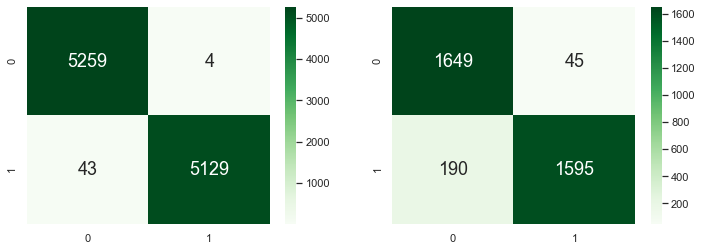

In [36]:
train_and_predict(healthProd, 13, 800)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9966740576496674
True Negative Rate      :  0.9964507542147294
True Positive Rate      :  0.9968971631205674
False Negative Rate     :  0.0031028368794326243
False Positive Rate     :  0.00354924578527063

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9208776595744681
True Negative Rate      :  0.953519256308101
True Positive Rate      :  0.8881491344873502
False Negative Rate     :  0.1118508655126498
False Positive Rate     :  0.04648074369189907


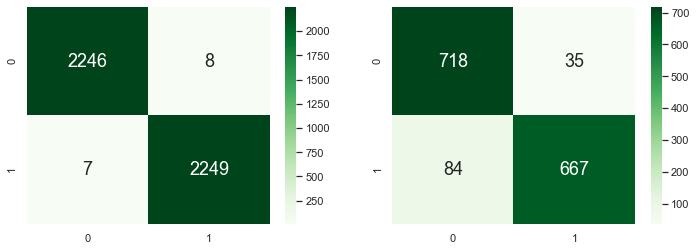

In [37]:
train_and_predict(autoProd, 13, 300)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9949575371549894
True Negative Rate      :  0.9962636776087537
True Positive Rate      :  0.9936658749010293
False Negative Rate     :  0.006334125098970704
False Positive Rate     :  0.0037363223912463303

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.8881369426751592
True Negative Rate      :  0.9428347689898199
True Positive Rate      :  0.8315789473684211
False Negative Rate     :  0.16842105263157894
False Positive Rate     :  0.05716523101018011


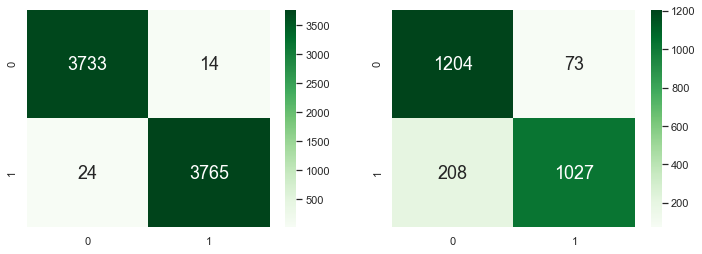

In [38]:
train_and_predict(CompAcProd, 13, 700)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9943526754200198
True Negative Rate      :  0.995213963963964
True Positive Rate      :  0.9934862645143019
False Negative Rate     :  0.006513735485698103
False Positive Rate     :  0.004786036036036036

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.878864887759424
True Negative Rate      :  0.9222222222222223
True Positive Rate      :  0.836272040302267
False Negative Rate     :  0.163727959697733
False Positive Rate     :  0.07777777777777778


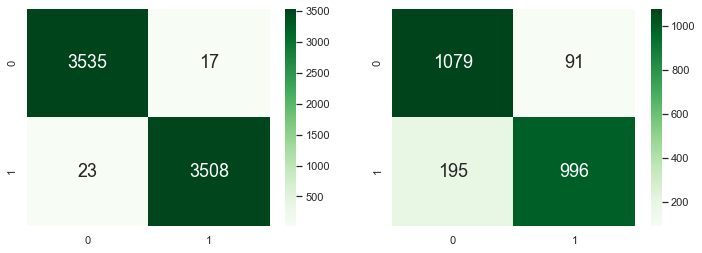

In [39]:
train_and_predict(furnitureProd, 13, 900)

# Check Point: Analysis 


After feeding in the best hyperparameters obtained through the GV Search, it can be seen that the train and test classification accuracy is very similar. This suggests that no overfitting occurred. Overfitting occurs when the train dataset has good classification accuracy, true positive and true negative but terrible classification accuracy, true positive and true negative when test data is used. In the above scenario, the classification accuracy, true positive and true negative is similar for both test and train. Hence, no overfitting has occurred. 

However, classification accuracy, true positive and true negative is still very high and this could be due to the upsampling of review score 0 done earlier. Upscaling can lead to overfitting. 

# In Conclusion and summary to the entire project, 
A decision tree (part 6) is a basic machine learning tool that did not provide a very high classification accuracy(65% to 75%), true positive(60% to 85%) and true negative(50% to 60%). There was a large distribution of these values across product types too. Every time the notebook is run, the train and test classification accuracy would differ from a range of 1% to 10%. Additionally, false positive was above 40% for most product types across multiple runs of the ipynb. This shows that the machine learning tool was not the best. 

Another option was to run random forest. A random forest uses a 'forest', a multitude of decisions trees that help to classify the data points into the different review scores. The reason why random forest works so well is that "A large number of relatively uncorrelated models (trees) operating as a committee will outperform any of the individual constituent models." [1]

There is low correlation between the trees and the trees help to cover each others errors to enable the most accurate classification. Hence we see that the random forest does enable better classification in part 7. Classification accuracy increase above 80% and false positive rates fell below 30%. Train and test were similar in terms of classification accuracy. 

False positives are generally bad given our reseach question. This is because sellers want to adjust their **actual delivery time**, **the difference between actual and estimated wait time**, **freight value**, **payment value**, **payment installment** such that they obtain the best review score 1 which is translated to 3 to 5 review score. If they adjust these factors and get a false positive, then they may predict a high review score but end up getting a low one. 

Hence, although the classification accuracy is relatively better, an additional step must be done to reduce the false positive. Tuning of hyperparameters must be done to achieve the highest possible classification accuracy, true positive and true negative and lowest possible false positive and false negative. Hyperparameters are used to make the random forest. There are many hyperparameters but for the scope of this project max_depth and n_estimators were chosen. max_depth is the maximum depth each decision tree goes in the 'forest' of trees. n_estimators is the number of trees in the forest. [2]

To find the best hyperparemeters a Grid Search is done.[3][4][5][6][7][8]

Grid Search will then run a range for the hyperparameters as seen in part 7. The definition provided by Sci-Kit is "The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid." 
Cross validation is defined as "Cross validation is a statistical method used to estimate the performance (or accuracy) of machine learning models." [9]

Best score is the "Mean cross-validated score of the best_estimator". Since cv = 5, the train and test split will occur five times for each hyperparameter. The best score is calculated for each try and for each combination of hyperparameters. The best score will return the average of the best hyperparameter combination in those 5 tries. 

This function will return the best hyperparameters max_depth and n_estimators. These are then run into the random forest in this very ipynb. Seen from above, classification accuracy, true positive and true negative are above 95% and false positive and false negative are below 1% for all product types. Train and test data are very similar. Hence, there is no overfitting as explained earlier. 


Reference List (for this notebook):

1. “sklearn.ensemble.randomforestclassifier¶.” [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html. [Accessed: 21-Apr-2021]. 


2. R. Meinert, “Optimizing Hyperparameters in Random Forest Classification,” Medium, 07-Jun-2019. [Online]. Available: https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6. [Accessed: 21-Apr-2021]. 


3. M. Sharma, “Grid Search for Hyperparameter Tuning,” Medium, 21-Mar-2020. [Online]. Available: https://towardsdatascience.com/grid-search-for-hyperparameter-tuning-9f63945e8fec. [Accessed: 21-Apr-2021]. 


4. “sklearn.model_selection.GridSearchCV¶,” scikit. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html. [Accessed: 21-Apr-2021]. 


5. J. Brownlee, “Hyperparameter Optimization With Random Search and Grid Search,” Machine Learning Mastery, 18-Sep-2020. [Online]. Available: https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/. [Accessed: 21-Apr-2021]. 


6. Shahul ES Freelance Data Scientist | Kaggle Master Data science professional with a strong end to end data science/machine learning and deep learning (NLP) skills. Experienced working in a Data Science/ML Engineer role in multiple startups. K, S. ES, Freelance Data Scientist | Kaggle Master Data science professional with a strong end to end data science/machine learning and deep learning (NLP) skills. Experienced working in a Data Science/ML Engineer role in multiple startups. Kaggle Kernels Master ra, and F. me on, “Hyperparameter Tuning in Python: a Complete Guide 2021,” neptune.ai, 19-Mar-2021. [Online]. Available: https://neptune.ai/blog/hyperparameter-tuning-in-python-a-complete-guide-2020#:~:text=Hyperparameter%20tuning%20is%20the%20process,maximum%20performance%20out%20of%20models. [Accessed: 21-Apr-2021]. 


7. R. Joseph, “Grid Search for model tuning,” Medium, 29-Dec-2018. [Online]. Available: https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e. [Accessed: 21-Apr-2021]. 


8. abuabu 54777 silver badges1616 bronze badges, Mischa LisovyiMischa Lisovyi                    2, and Vivek KumarVivek Kumar 28.8k66 gold badges7575 silver badges109109 bronze badges, “Interpreting sklearns' GridSearchCV best score,” Stack Overflow, 01-Feb-1967. [Online]. Available: https://stackoverflow.com/questions/50232599/interpreting-sklearns-gridsearchcv-best-score. [Accessed: 21-Apr-2021]. 


9. H. M. -, By, -, Hussain MujtabaHussain is a computer science engineer who specializes in the field of Machine Learning.He is a freelance programmer and fancies trekking, H. Mujtaba, Hussain is a computer science engineer who specializes in the field of Machine Learning.He is a freelance programmer and fancies trekking, and P. enter your name here, “What is Cross Validation in Machine learning? Types of Cross Validation,” GreatLearning Blog: Free Resources what Matters to shape your Career!, 24-Sep-2020. [Online]. Available: https://www.mygreatlearning.com/blog/cross-validation/. [Accessed: 21-Apr-2021]. 